In [1]:
# ! pip install matplotlib

In [2]:
import numpy as np
from matplotlib import pyplot as plt
# from numba import jit
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from adamp_tf import AdamP
from sgdp_tf import SGDP
from pathlib import Path
from tensorflow.keras import backend as K

In [2]:
from tensorflow import keras

In [3]:
import tensorflow as tf

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
from skimage.transform import resize, rotate

In [8]:
class DataGeneratorDivide(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, path_to_dataset, batch_size=32, 
                 shuffle=True, use_augmentations=False,
                 mode='train', val_percent=0.3):
        """
        mode: train or val
        """
        self.batch_size = batch_size
        self.val_percent = val_percent
        self.mode = mode
        self.initialize()
        
        self.shuffle = shuffle
        self.on_epoch_end()
        self.use_aug = use_augmentations

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, Y = self.__data_generation(indexes)

        return X, Y
     
    def initialize(self):
        slice_nums = list(set(
            int(file.name.split('_')[-1].split('.')[0]) for file in (path_to_dataset / 'gt').iterdir()
        ))
        slice_nums = sorted(list(slice_nums))
        num_of_slices = len(slice_nums)
        
        val_num = int(num_of_slices * self.val_percent)
        if self.mode == 'train':
            curr_slices_to_use = slice_nums[val_num:]
        else:
            curr_slices_to_use = slice_nums[:val_num]
            
        self.curr_slices_to_use = curr_slices_to_use
        
        self.X, self.Y = [], []
        for file in (path_to_dataset / 'images').iterdir():
            slice_num = int(file.name.split('_')[-1].split('.')[0])
            if slice_num in self.curr_slices_to_use:
                self.X.append(file)
                self.Y.append(path_to_dataset / 'gt' / file.name)
                   
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        X = [np.load(self.X[ind]) for ind in indexes]
        Y = [np.load(self.Y[ind]) for ind in indexes]
        max_w, max_h = 256, 256
        for i, img in enumerate(X):
            w, h = X[i].shape
            if self.use_aug:
                X[i], y[i] = augment_img_mask(X[i], y[i])
            X[i] = resize(X[i], (256, 256), preserve_range=True) 
            Y[i] = resize(Y[i], (256, 256), preserve_range=True) 
        X, Y = np.array(X)[:, :, :, np.newaxis], np.array(Y)[:, :, :, np.newaxis]
        return Y, Y

In [10]:
path_to_dataset=Path('./dataset')

In [11]:
dg_train = DataGeneratorDivide(path_to_dataset, mode='train', val_percent=0.2)
dg_val = DataGeneratorDivide(path_to_dataset, mode='val', val_percent=0.2)

In [187]:
def create_encoder_block(
    x, num_filters = 16
):
    c = Conv2D(num_filters, (3, 3), 
                activation='relu', 
                kernel_initializer='he_normal', 
                kernel_regularizer=wd_reg, 
                padding='same') (x)
    c = BatchNormalization()(c)
    c = MaxPooling2D((2, 2)) (c)
    return c

In [241]:
def UpSampling2DBicubic(stride=2, **kwargs):
    def layer(x):
        input_shape = K.int_shape(x)
        output_shape = (stride * input_shape[1], stride * input_shape[2])
        return tf.image.resize(x, output_shape, method='bicubic')
    return Lambda(layer, **kwargs)

In [242]:
def create_decoder_block(
    x, num_filters = 16, type_upsampling='transpose'
):
    if type_upsampling == 'transpose':
        u = Conv2DTranspose(num_filters, (4, 4), strides=(2, 2), 
                            padding='same', kernel_regularizer=wd_reg) (x)
    else:
        u = UpSampling2DBicubic(stride=2) (x)
        u = Conv2D(num_filters, (3, 3), 
                activation='relu', 
                kernel_initializer='he_normal',
                kernel_regularizer=wd_reg,
                padding='same') (u)
        
    c = BatchNormalization()(u)
    c = Conv2D(num_filters, (3, 3), 
                activation='relu', 
                kernel_initializer='he_normal',
                kernel_regularizer=wd_reg,
                padding='same') (c)
    return c

In [245]:
from tensorflow.keras.applications import ResNet50V2, ResNet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Lambda, Dense, Flatten, MaxPooling2D, BatchNormalization, Conv2D, Dropout, LeakyReLU, UpSampling2D
from tensorflow.keras.regularizers import l2

filters_list = [16, 32, 64, 128]

keras.backend.clear_session()

wd = 0 
wd_reg = l2(wd)

inputs = Input((256, 256, 1))
x = inputs

for num_filters in filters_list:
    x = create_encoder_block(x, num_filters)

for num_filters in filters_list[::-1]:
    x = create_decoder_block(x, num_filters, type_upsampling='upsampling')
    

outputs = Conv2D(1, (1, 1), activation='linear', dtype='float32') (x)

model = keras.Model(inputs=[inputs], outputs=[outputs])

In [246]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)       

In [249]:
dg_train = DataGeneratorDivide(path_to_dataset, mode='train', batch_size=8, val_percent=0.2)
dg_val = DataGeneratorDivide(path_to_dataset, mode='val', batch_size=8, val_percent=0.2)

In [252]:
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.002)
exp_decay = tf.keras.optimizers.schedules.ExponentialDecay(0.1, 60_000, 0.96)
sgd_opt = tf.keras.optimizers.SGD(learning_rate=exp_decay, momentum=0.9)
optimizer_adamp = AdamP(learning_rate=0.002, beta_1=0.9, beta_2=0.999, weight_decay=1e-2)
# optimizer_sgdp = SGDP(learning_rate=0.1, weight_decay=1e-5, momentum=0.9, nesterov=True)

In [256]:
model.compile(optimizer=optimizer_adamp, loss='mse', metrics=['mse', 'mae'])

In [258]:
tf.keras.mixed_precision.experimental.set_policy('mixed_float16')

In [261]:
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir="./models/model25",
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq=1,
    profile_batch=2,
    embeddings_freq=0,
)

In [262]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(min_delta=0.00001, patience=5, verbose=3)

In [269]:
model_check = ModelCheckpoint('./best_weights_25.h5', save_best_only=True, verbose=1)

model.fit(
    dg_train, 
    epochs=60,
    validation_data=dg_val,
    callbacks=[model_check, tb_callback, reduce_lr], initial_epoch=0, # workers=6, max_queue_size=20
) 

Epoch 1/60
696/696 [==============================] - ETA: 0s - loss: 0.0207 - mse: 0.0207 - mae: 0.0731
Epoch 00001: val_loss improved from inf to 0.00221, saving model to ./best_weights_25.h5
696/696 [==============================] - 209s 300ms/step - loss: 0.0207 - mse: 0.0207 - mae: 0.0731 - val_loss: 0.0022 - val_mse: 0.0022 - val_mae: 0.0347
Epoch 2/60
696/696 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mae: 0.0302
Epoch 00002: val_loss improved from 0.00221 to 0.00148, saving model to ./best_weights_25.h5
696/696 [==============================] - 207s 298ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0302 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0279
Epoch 3/60
696/696 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - mae: 0.0267
Epoch 00003: val_loss improved from 0.00148 to 0.00135, saving model to ./best_weights_25.h5
696/696 [==============================] - 208s 299ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0

Epoch 17/60
696/696 [==============================] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - mae: 0.0237
Epoch 00017: val_loss improved from 0.00116 to 0.00116, saving model to ./best_weights_25.h5
696/696 [==============================] - 207s 297ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0237 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0240
Epoch 18/60
696/696 [==============================] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - mae: 0.0237
Epoch 00018: val_loss improved from 0.00116 to 0.00116, saving model to ./best_weights_25.h5
696/696 [==============================] - 207s 297ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0237 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0240
Epoch 19/60
696/696 [==============================] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - mae: 0.0237
Epoch 00019: val_loss improved from 0.00116 to 0.00116, saving model to ./best_weights_25.h5
696/696 [==============================] - 207s 297ms/step - loss: 0.0011 - mse: 0.0011 -

Epoch 41/60
696/696 [==============================] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - mae: 0.0237
Epoch 00041: val_loss did not improve from 0.00116

Epoch 00041: ReduceLROnPlateau reducing learning rate to 2.000000165480742e-09.
696/696 [==============================] - 207s 297ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0237 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0240
Epoch 42/60
696/696 [==============================] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - mae: 0.0237
Epoch 00042: val_loss did not improve from 0.00116
696/696 [==============================] - 207s 297ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0237 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0240
Epoch 43/60
696/696 [==============================] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - mae: 0.0237
Epoch 00043: val_loss improved from 0.00116 to 0.00116, saving model to ./best_weights_25.h5
696/696 [==============================] - 207s 297ms/step - loss: 0.0011 - mse: 0.0011 - ma

In [218]:
model = best_model

In [219]:
inputs = Input((256, 256, 1))

feature_model = keras.Model(
    inputs=model.inputs,
    outputs=[
        model.get_layer(layer_name).output for layer_name in ['max_pooling2d_3']
    ]
)

In [221]:
img = x[0:1]

In [171]:
img.shape

(1, 256, 256, 1)

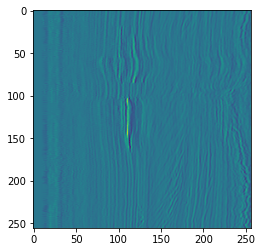

In [222]:
plt.imshow(img[0])
plt.show()

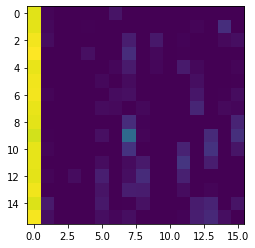

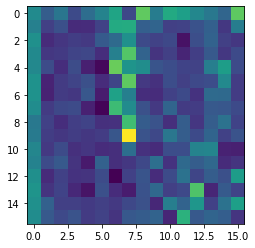

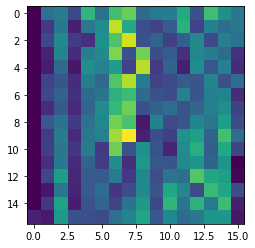

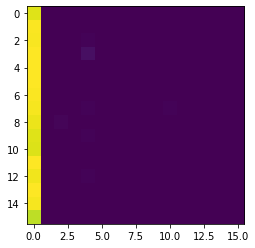

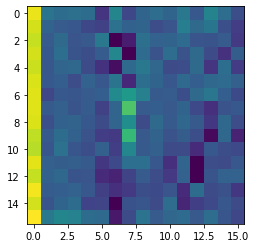

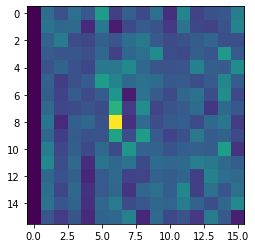

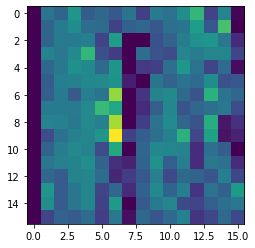

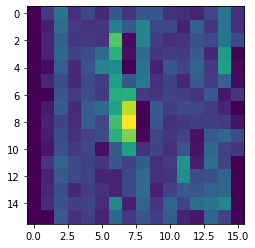

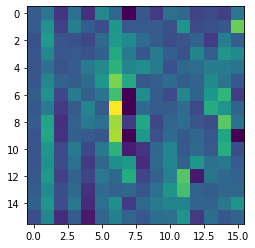

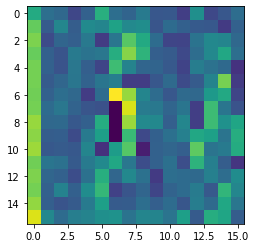

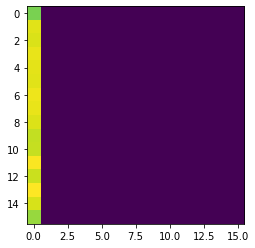

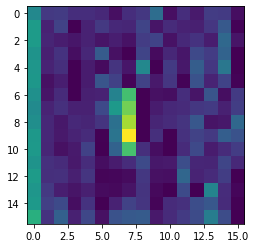

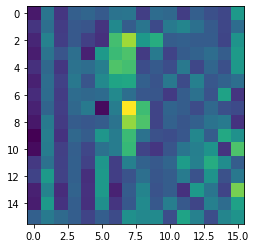

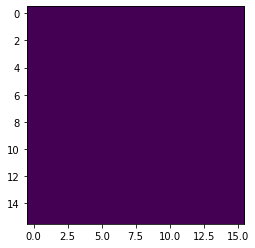

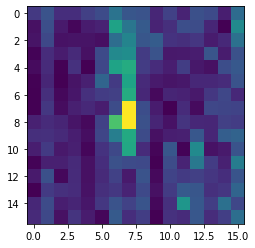

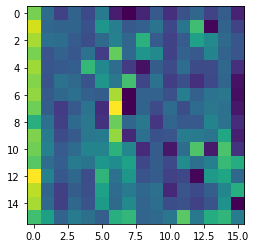

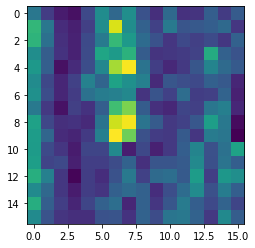

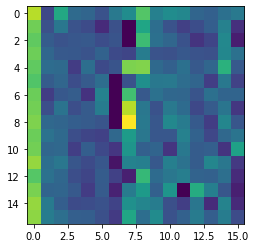

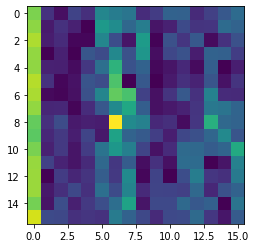

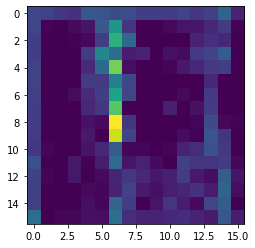

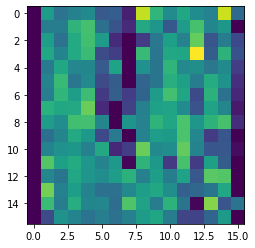

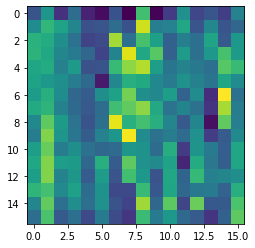

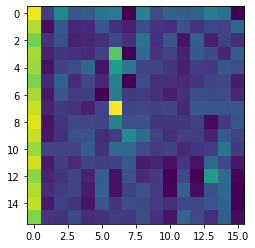

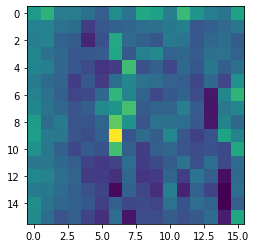

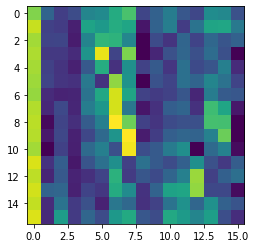

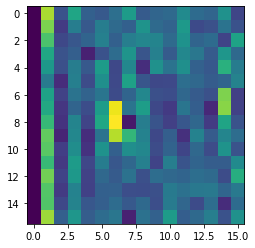

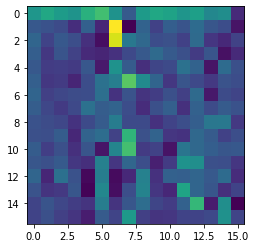

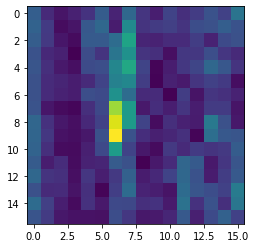

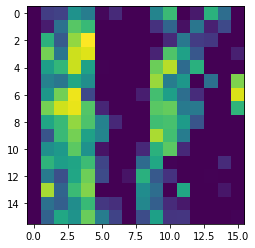

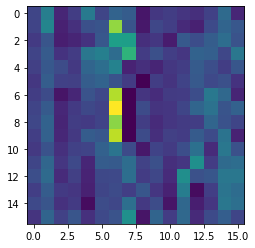

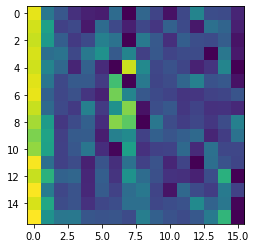

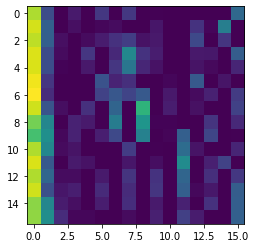

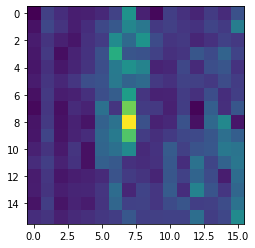

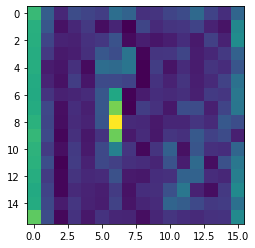

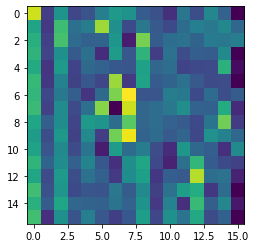

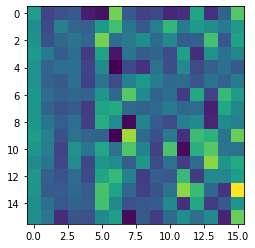

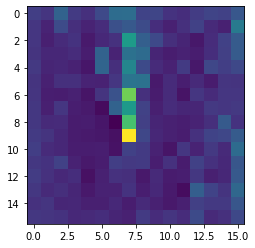

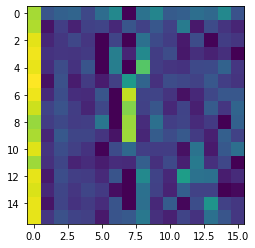

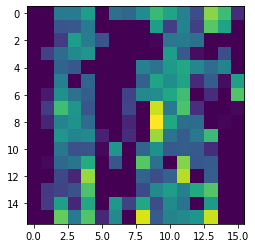

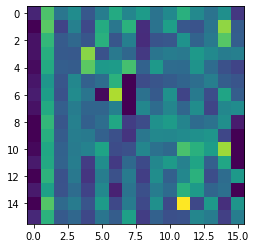

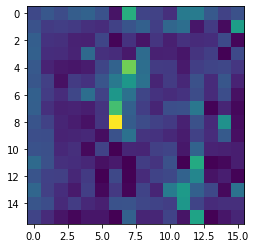

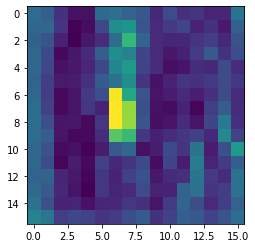

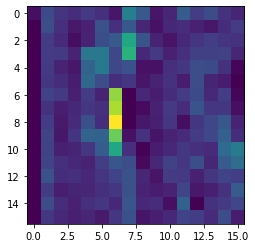

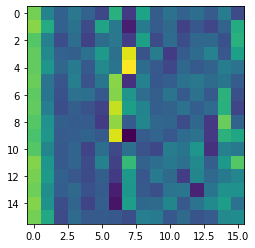

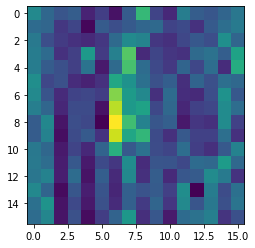

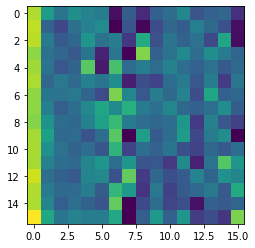

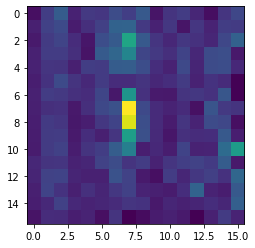

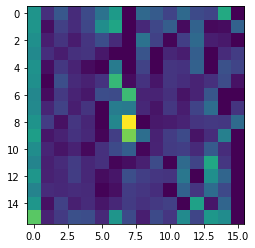

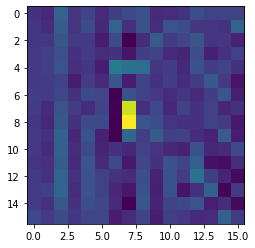

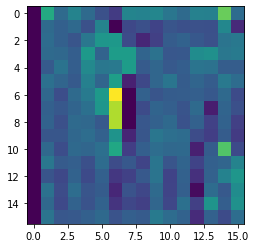

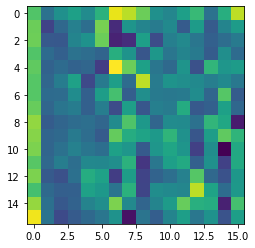

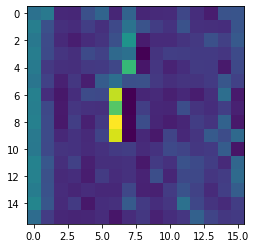

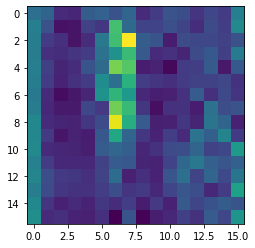

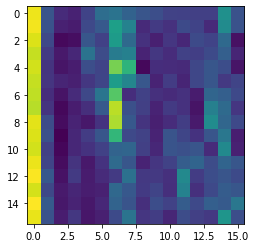

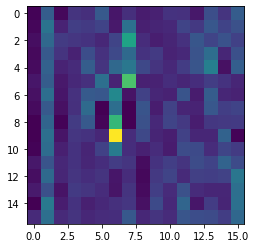

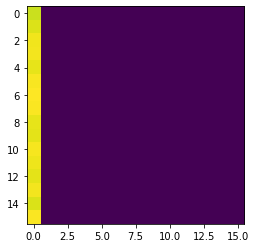

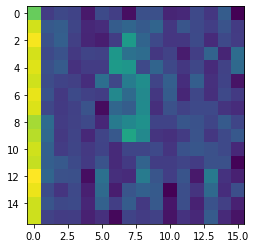

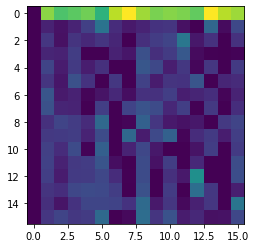

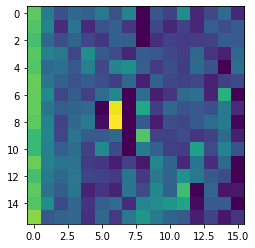

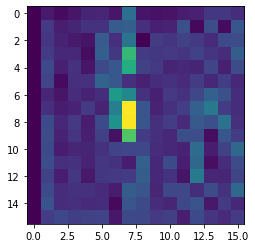

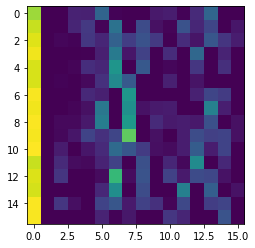

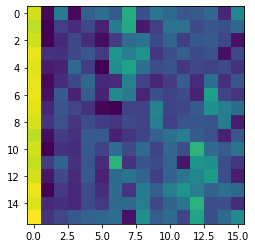

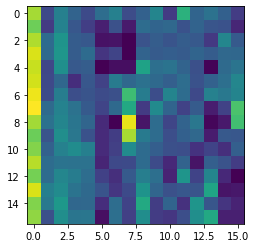

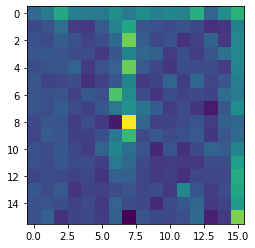

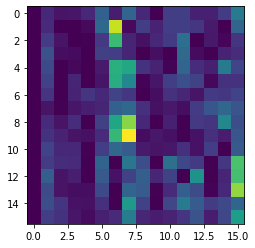

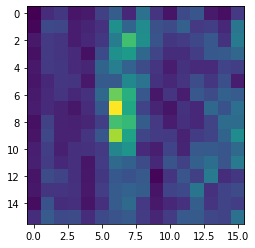

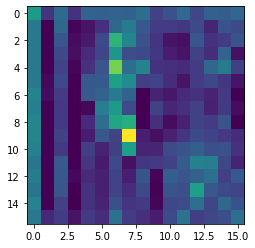

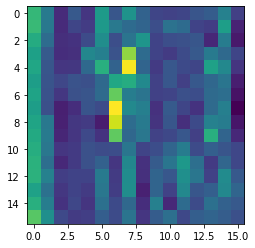

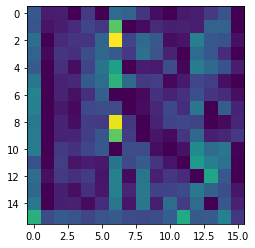

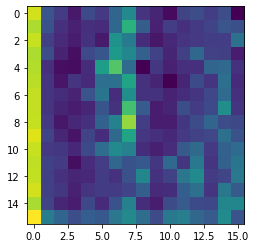

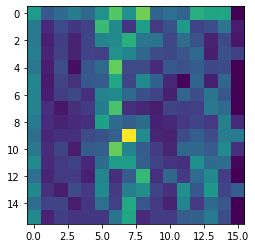

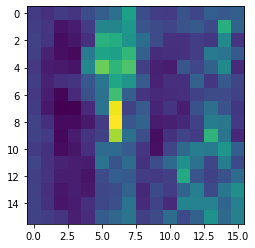

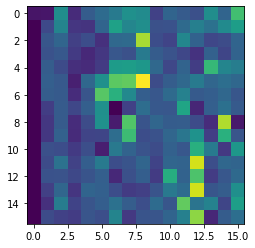

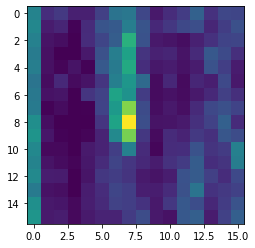

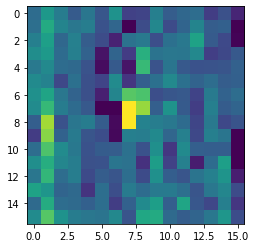

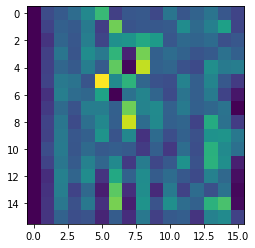

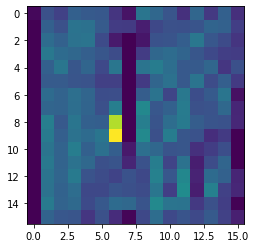

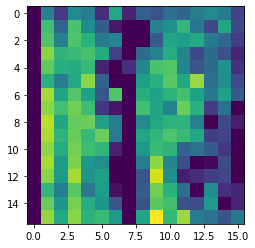

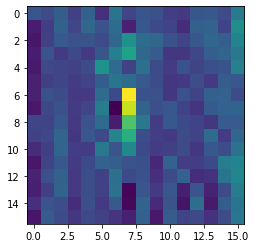

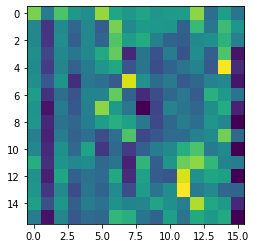

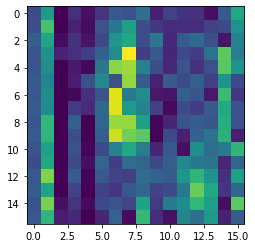

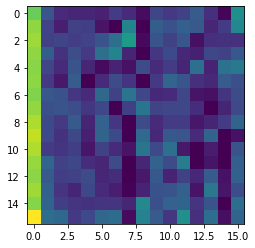

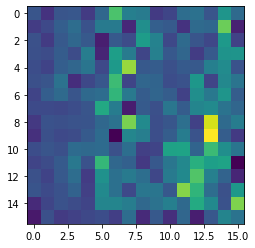

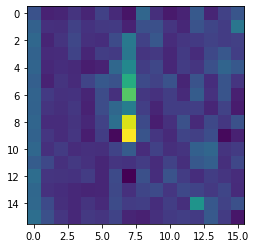

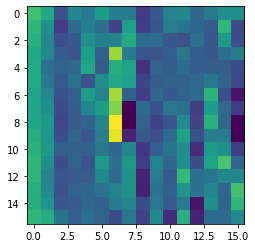

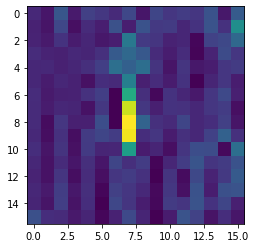

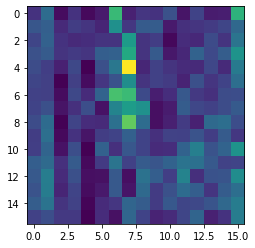

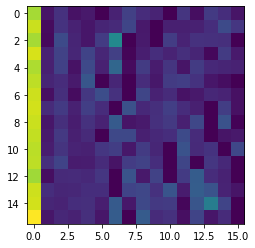

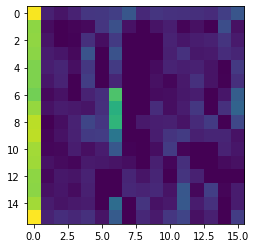

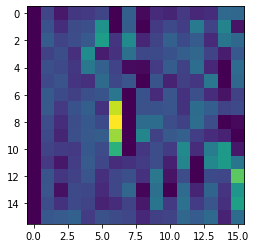

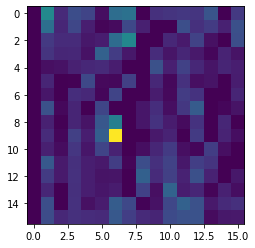

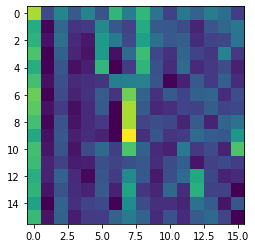

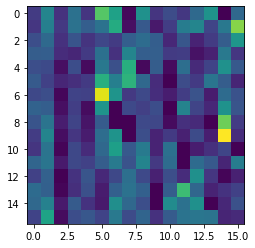

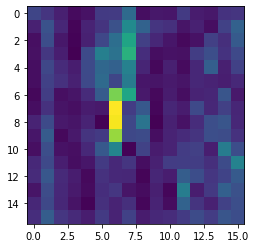

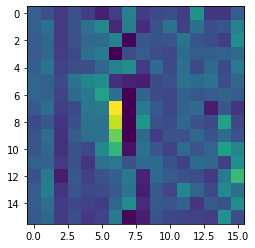

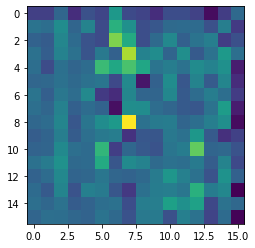

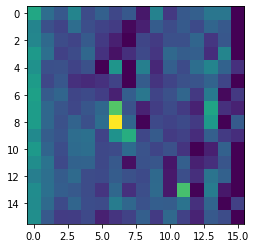

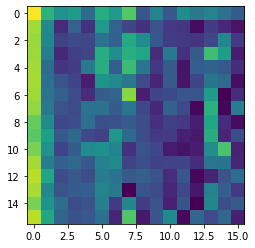

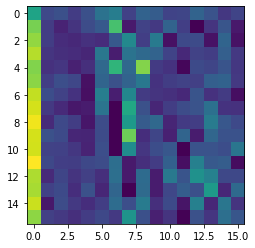

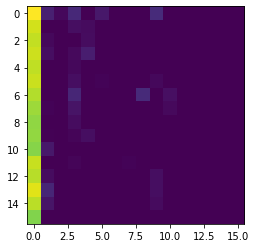

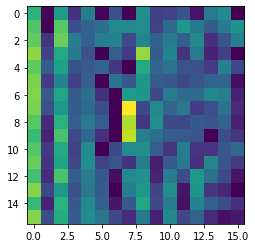

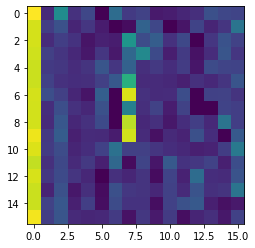

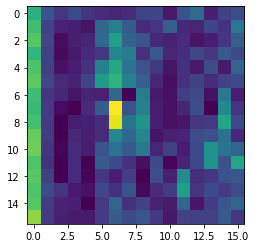

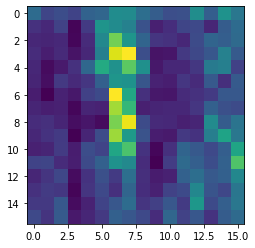

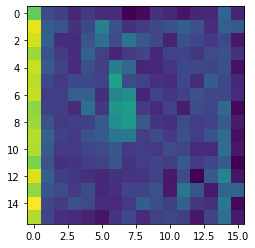

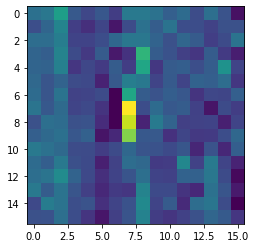

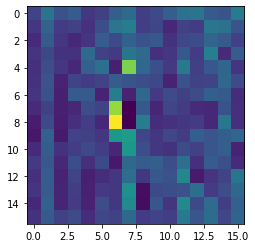

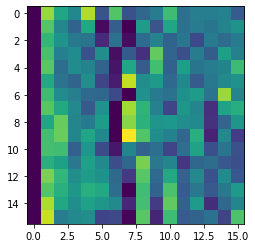

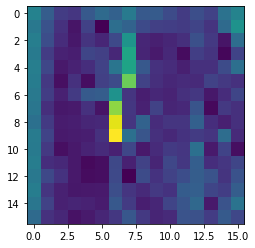

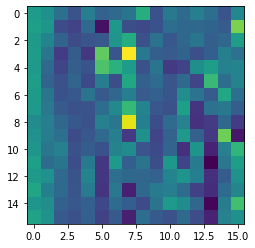

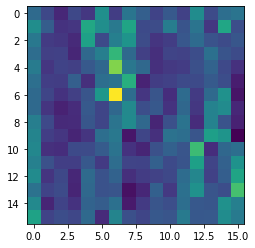

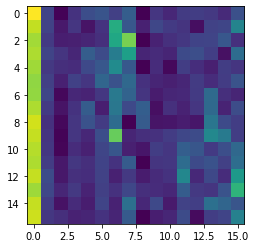

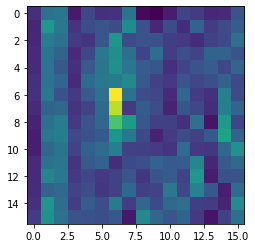

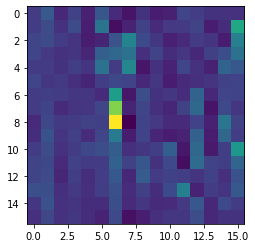

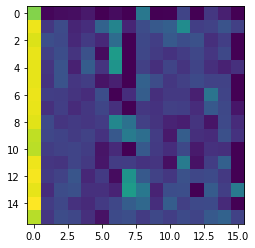

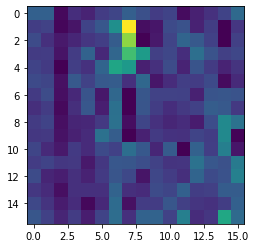

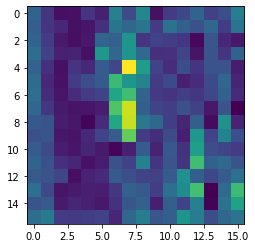

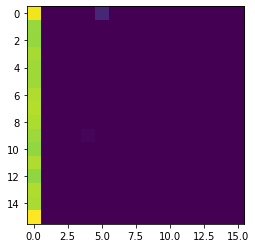

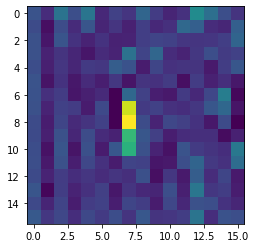

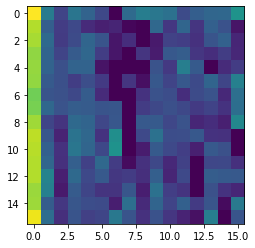

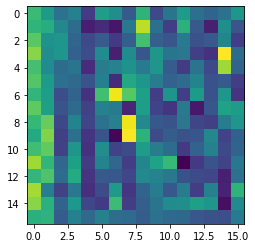

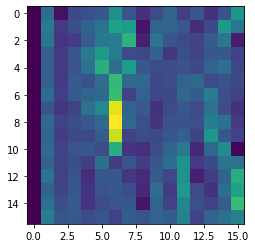

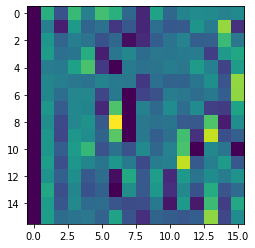

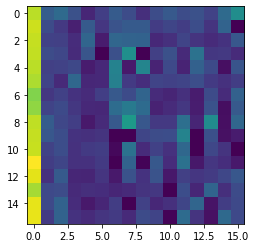

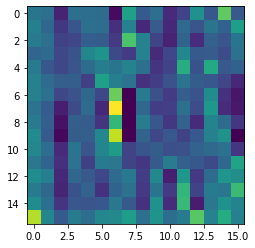

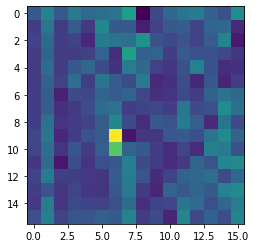

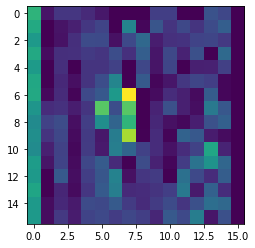

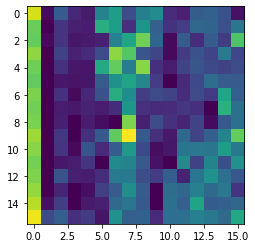

In [223]:
layer_features = feature_model(img)
features = layer_features[0]
for i in range(features.shape[-1]):
    img_feature = features[:, :, i] 
    img_feature /= img_feature.numpy().max()
    plt.imshow(img_feature.numpy().astype('float32'))
    plt.show()
        
#     print(layer_features.shape)

In [276]:
best_model = tf.keras.models.load_model('./best_weights_24.h5', compile=False)

In [273]:
best_model = model

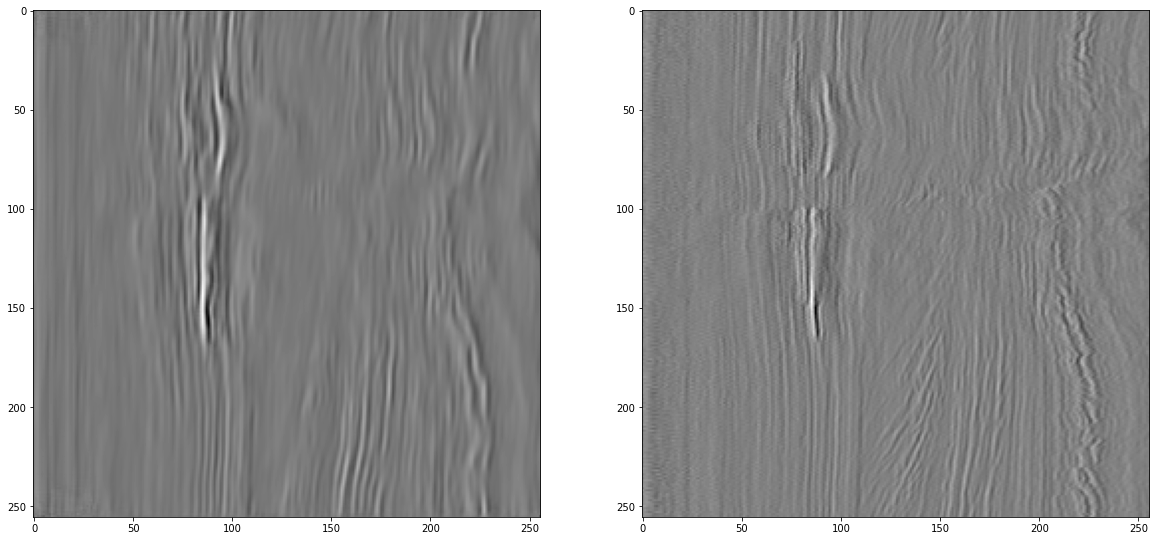

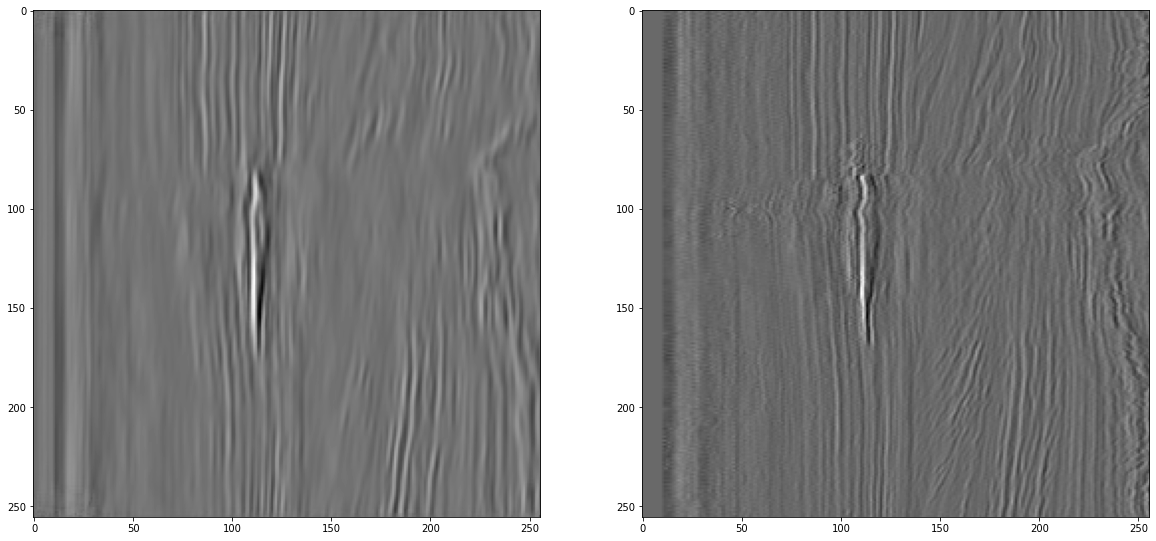

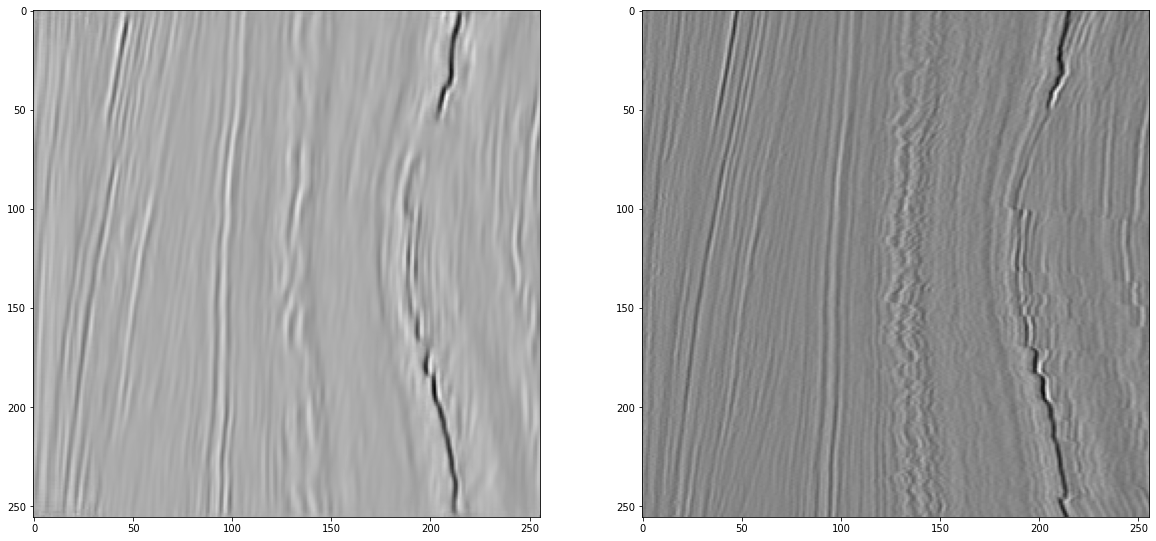

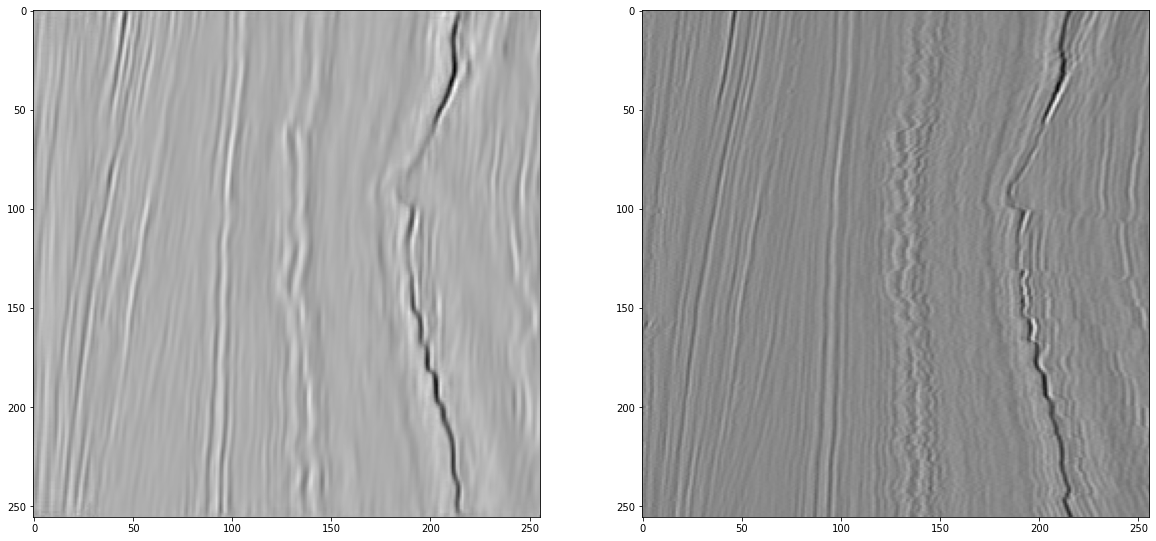

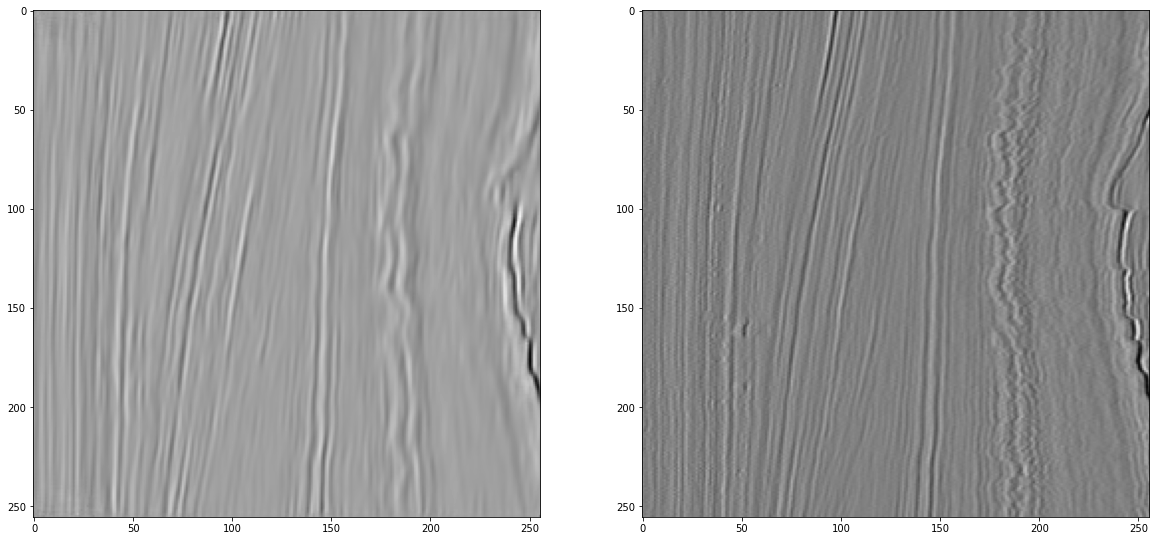

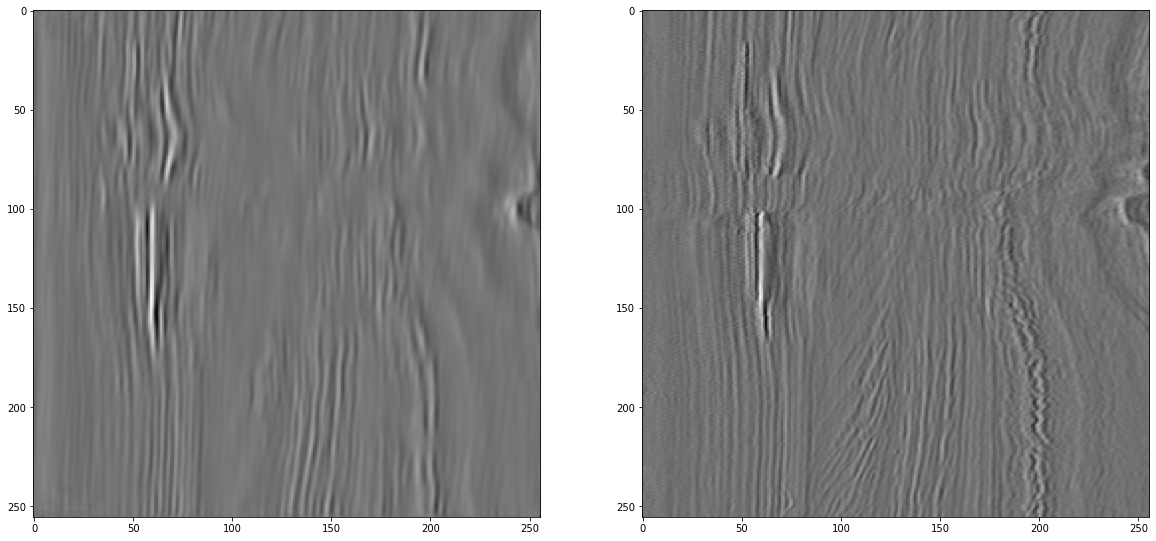

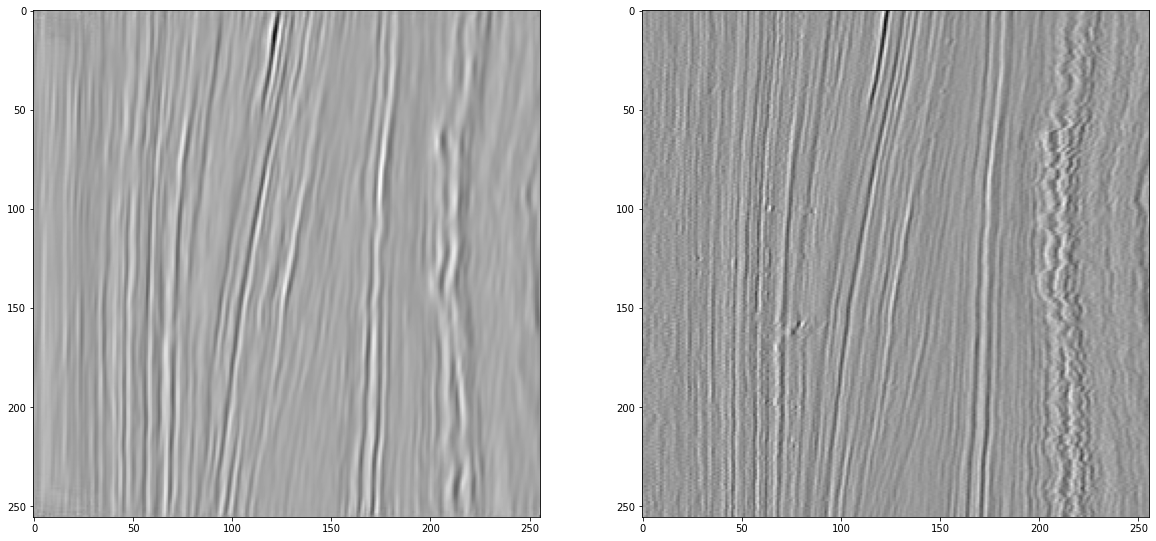

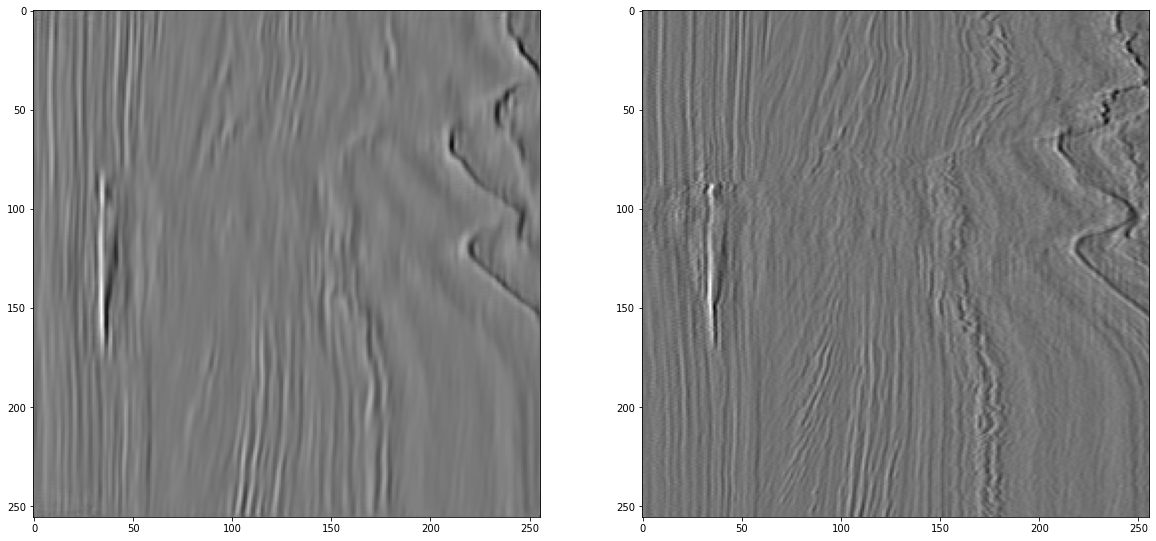

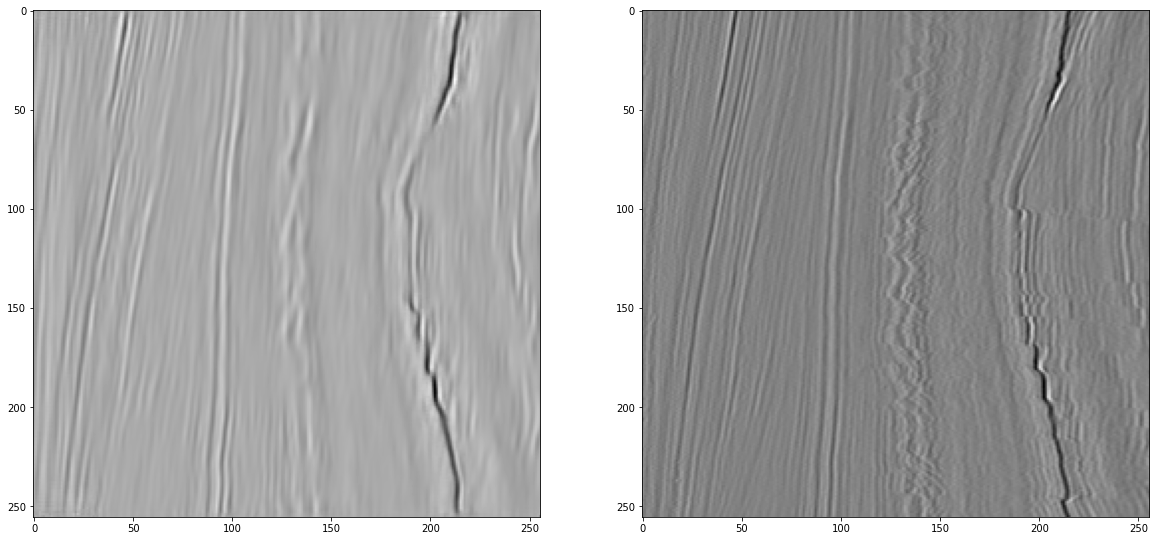

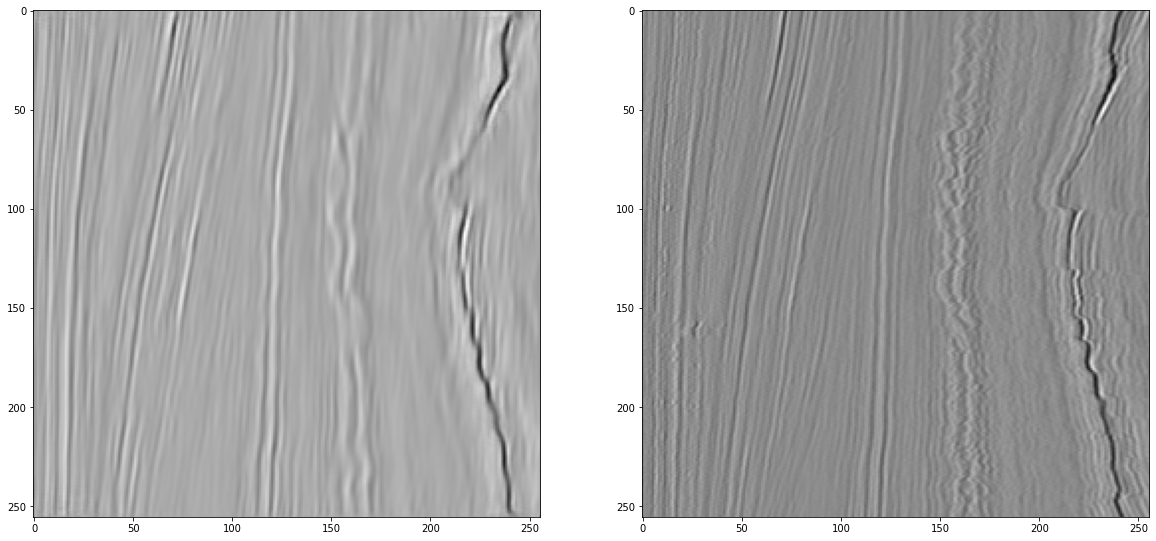

In [277]:
for ind, (x, y) in enumerate(dg_val):
    if ind == 10:
        break
    prediction = best_model.predict(x)
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    for pred, x_, y_ in zip(prediction, x, y):
        axes[0].imshow(pred, cmap='gray')
        axes[1].imshow(x_, cmap='gray')
#         axes[2].imshow(y_, cmap='gray')
    plt.show()